In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

Testing using a custom class as a layer to do the encoding inside of the autoencoder model. Will be made with some foobar data.

In [11]:
class OneHotEncodingLayer(layers.StringLookup):
    def __init__(self,max_tokens=None,output_mode='one_hot'):
        super().__init__(max_tokens=max_tokens,output_mode=output_mode)
        self.max_tokens = max_tokens
        self.output_mode = output_mode
            
    def adapt(self,data):
        self.vectorization.adapt(data)
        vocab = self.vectorization.get_vocabulary()
        self.depth = len(vocab)
        indices = [i[0] for i in self.vectorization([[v] for v in vocab]).numpy()]
        self.minimum = min(indices)
        
    def call(self,inputs):
        vectorized = self.vectorization.call(inputs)
        subtracted = tf.subtract(vectorized, tf.constant([self.minimum], dtype=tf.int64))
        encoded = tf.one_hot(subtracted, self.max_tokens)
        return layers.Reshape((self.max_tokens,))(encoded)
        
    def get_config(self):
        return {
            "max_tokens":self.max_tokens,
            "output_mode":self.output_mode,
            "vocabulary":self.vectorization.get_vocabulary()
        }

In [29]:
df = pd.DataFrame({
    "number":[5,6,1,2],
    "colour":["red","blue","red","yellow"],
    "size":['large','medium','large','medium']
})

categorical_input = layers.Input(shape=(1,), dtype=tf.string)
one_hot_layer = layers.StringLookup(output_mode='one_hot')
one_hot_layer.adapt(df['colour'].values)
encoded = one_hot_layer(categorical_input)

categorical_input2 = layers.Input(shape=(1,), dtype=tf.string)
one_hot_layer2 = layers.StringLookup(output_mode='one_hot')
one_hot_layer2.adapt(df['size'].values)
encoded2 = one_hot_layer2(categorical_input2)

numeric_input = layers.Input(shape=(1,), dtype=tf.float32)

concat = layers.concatenate([numeric_input, encoded, encoded2])

model = Model(inputs=[numeric_input, categorical_input, categorical_input2], outputs=[concat])
predicted = model.predict([df['number'], df['colour'], df['size']])
print(predicted)

[[5. 0. 1. 0. 0. 0. 0. 1.]
 [6. 0. 0. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 0. 0. 0. 1.]
 [2. 0. 0. 1. 0. 0. 1. 0.]]


In [43]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector,self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(6,activation='relu'),
            layers.Dense(3,activation='relu'),
            layers.Dense(2,activation='relu')
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(3,activation='relu'),
            layers.Dense(6,activation='relu'),
            layers.Dense(8,activation='sigmoid')
        ])
        
    def call(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [45]:
a = AnomalyDetector()
a.compile(optimizer='adam',loss='mae')
history = a.fit(predicted,predicted,
                epochs=3,
                batch_size=1,
                shuffle=True
               )

Epoch 1/3
4/4 [==============================] - 0s 2ms/step - loss: 0.8124
Epoch 2/3
4/4 [==============================] - 0s 2ms/step - loss: 0.8119
Epoch 3/3
4/4 [==============================] - 0s 2ms/step - loss: 0.8115


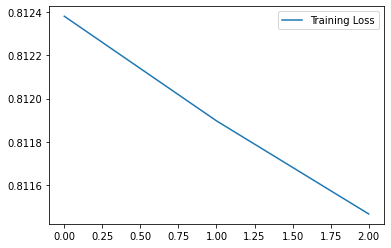

In [46]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="Training Loss")
plt.legend()

In [47]:
history